In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import math

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from plot_util import plotCorrelationMatrix, plotPerColumnDistribution, plotScatterMatrix

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

#pandas：
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 1. Read Data

In [2]:
df_train = pd.read_csv("Train_data.csv")
print("df_train shape:", df_train.shape)
display(df_train.head(1))

df_test = pd.read_csv("Test_data.csv")
print("df_test shape:", df_test.shape)
display(df_test.head(1))


df_train['train_test'] = 'train'
df_test['Item_Outlet_Sales'] = np.nan
df_test['train_test'] = 'test'
df_all = pd.concat([df_train,df_test])
print("df_all shape:", df_all.shape)

df_train shape: (8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138


df_test shape: (5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1


df_all shape: (14204, 13)


# 2. Exploratory Data Analysis

In [3]:
df_all.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [4]:
df_all.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
train_test                       2
dtype: int64

### 2.1 numeric features

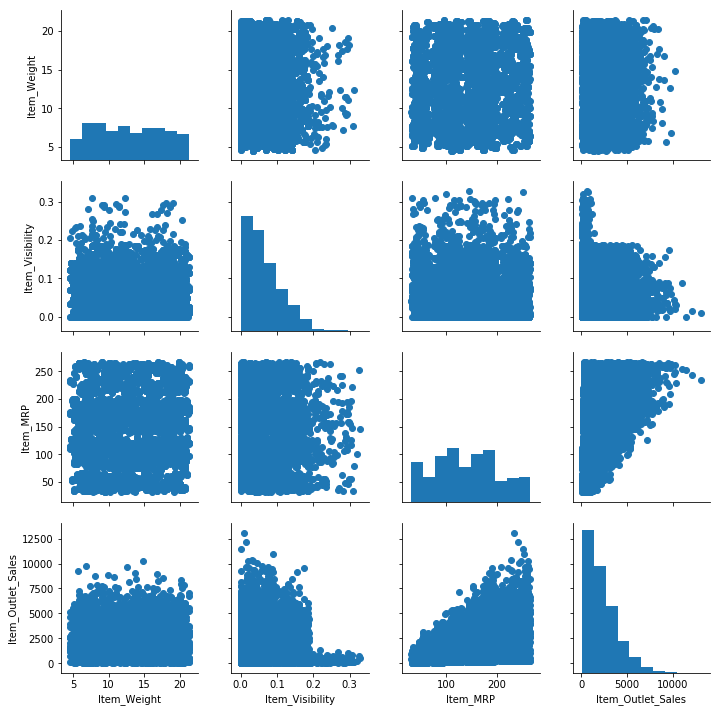

In [5]:
scatter_features = ['Item_Weight','Item_Visibility',
                    'Item_MRP', 'Item_Outlet_Sales']
g = sns.PairGrid(df_train[scatter_features])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
plt.show()

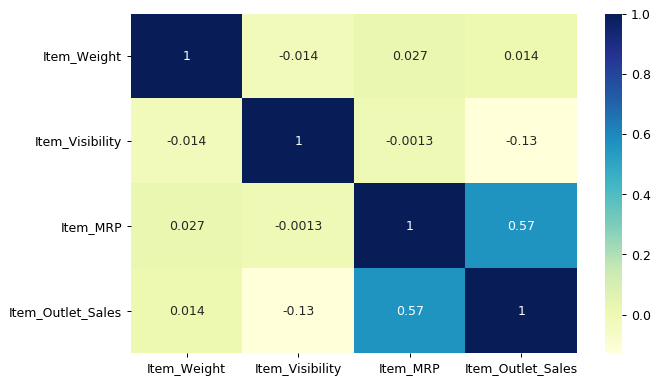

In [6]:
plt.figure(figsize=(8,5),dpi=90)
sns.heatmap(df_train[scatter_features].corr(), cmap="YlGnBu", annot=True)
plt.show()

### 2.2 categorical features

In [7]:
categorical_columns = df_train.select_dtypes(include=['object']).columns.drop(['Item_Identifier','train_test'])
categorical_columns

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')

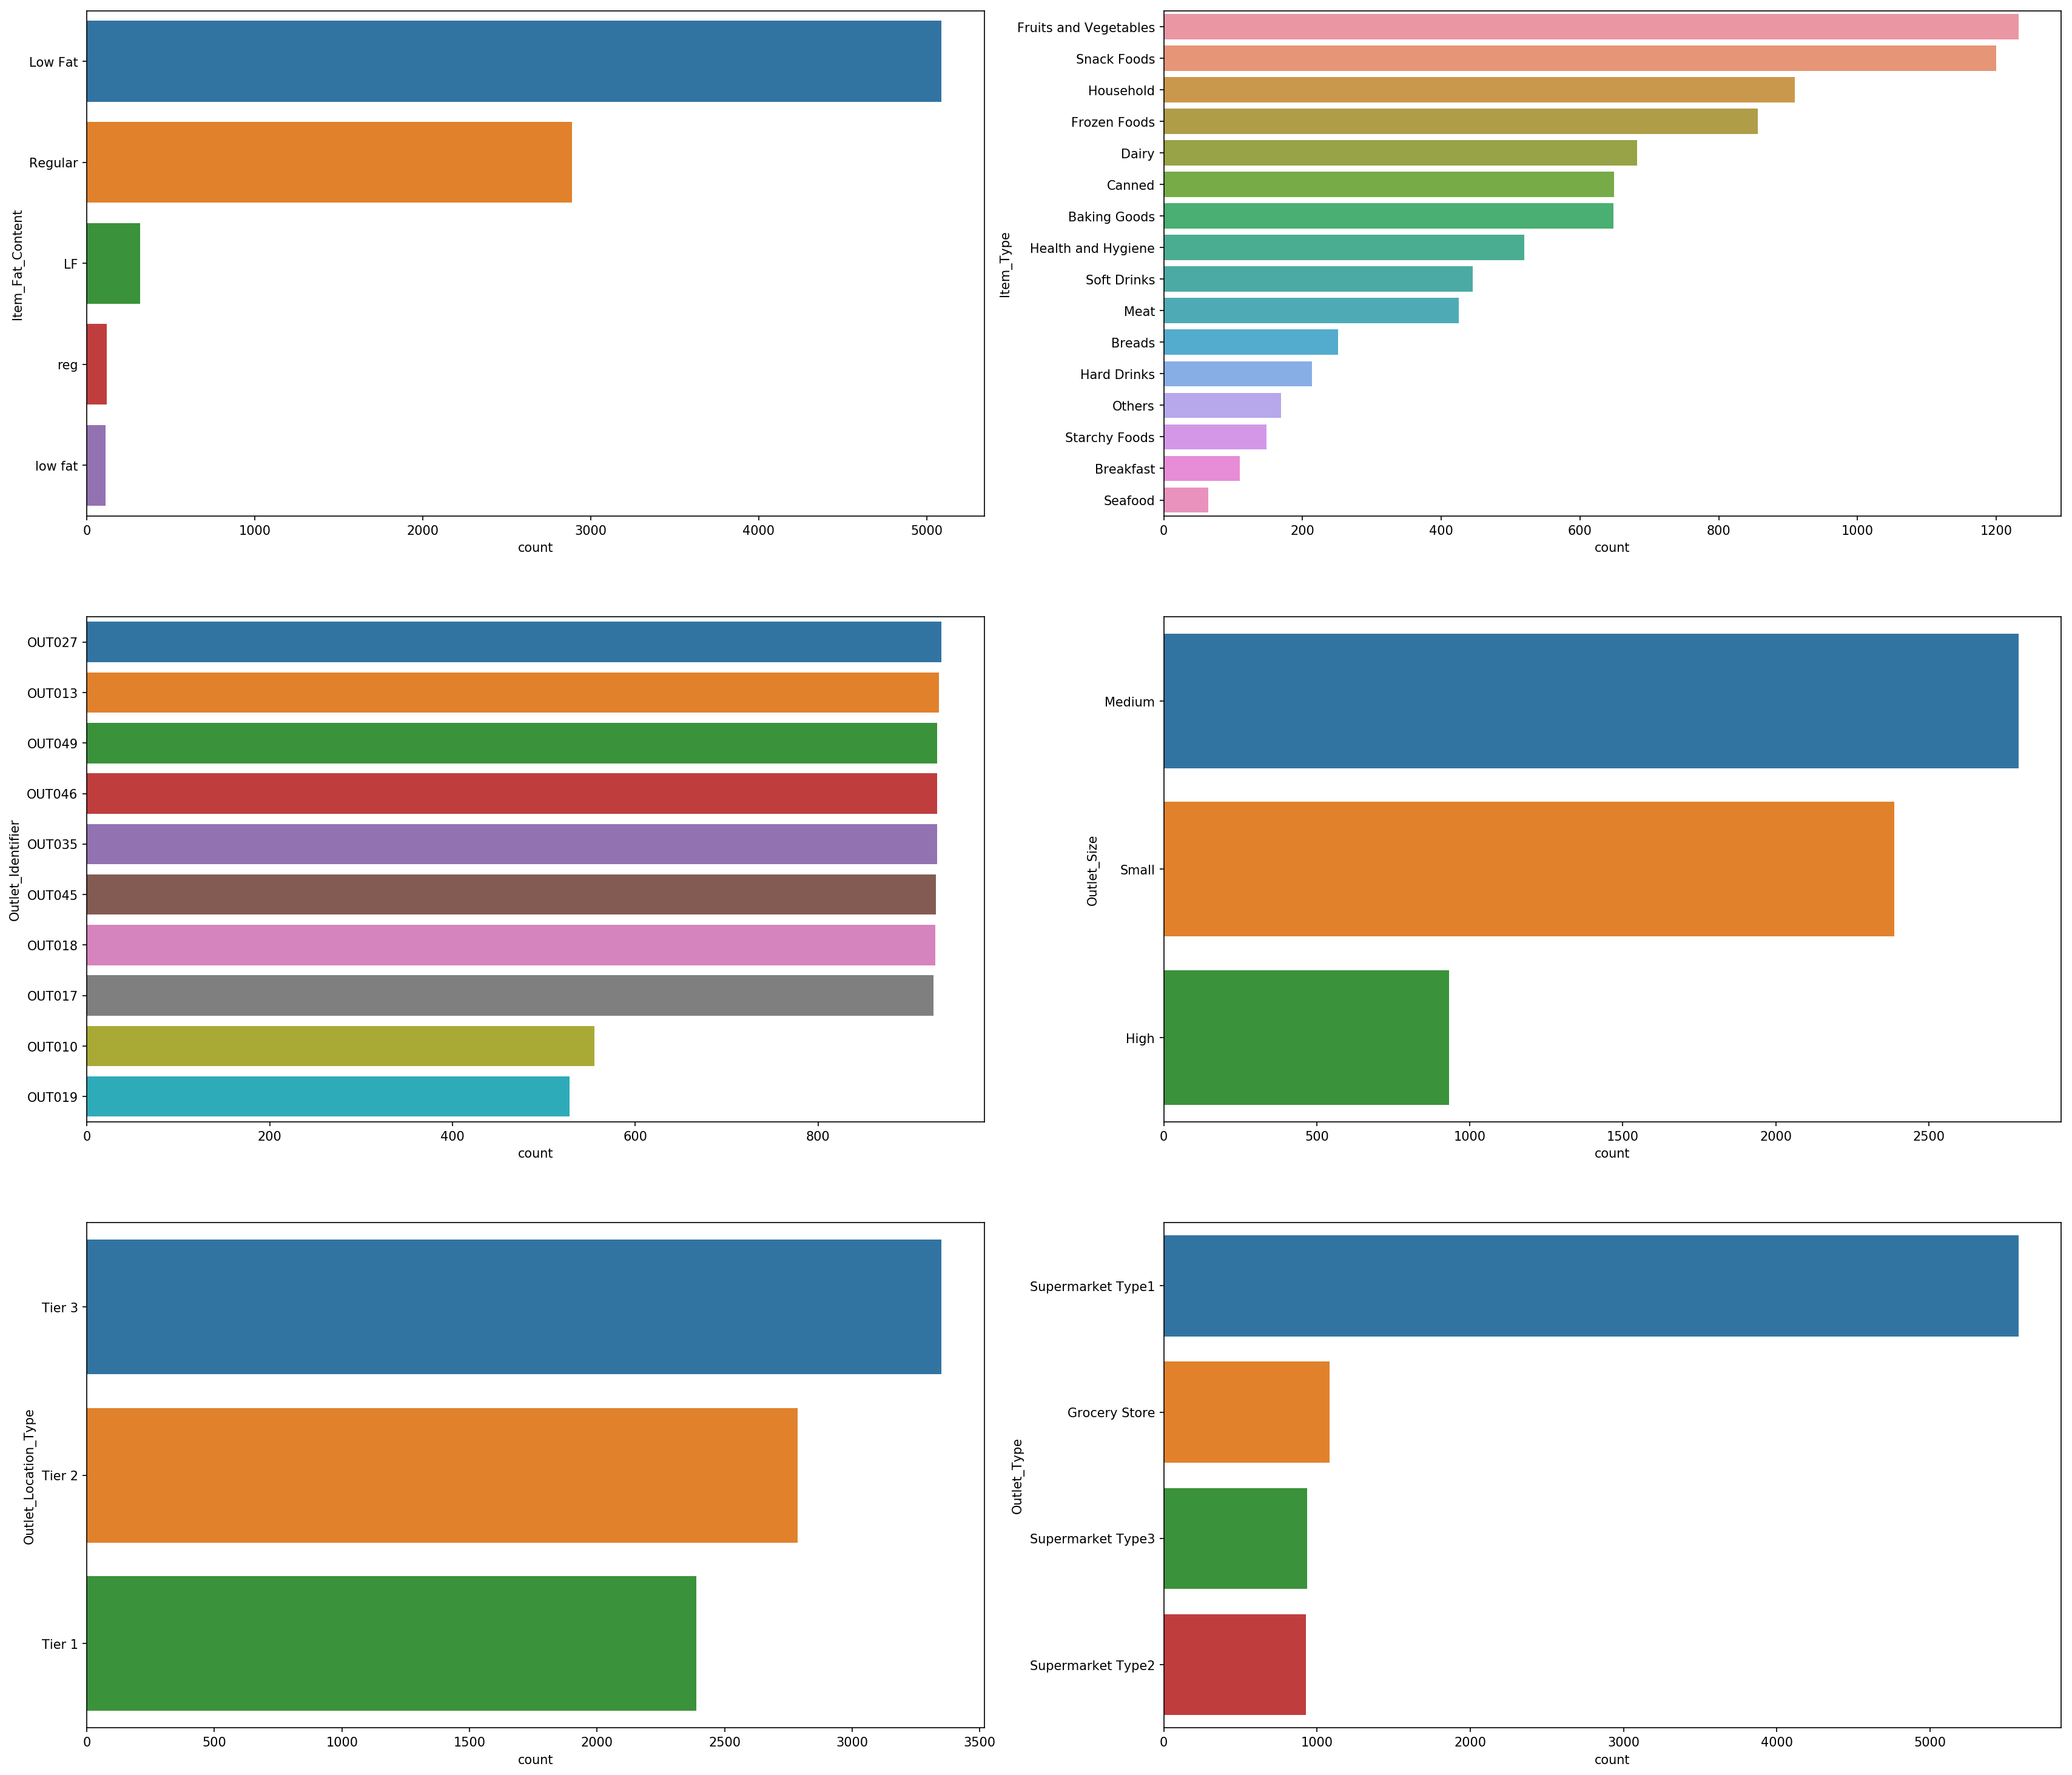

In [8]:
plt.figure(figsize=(28,25),dpi=150)

for i in range(0, len(categorical_columns)):
    plt.subplot(3,2,i+1)
    order = df_train[categorical_columns[i]].value_counts().index
    sns.countplot(y=categorical_columns[i], 
                data=df_train,  order=order)
plt.show()

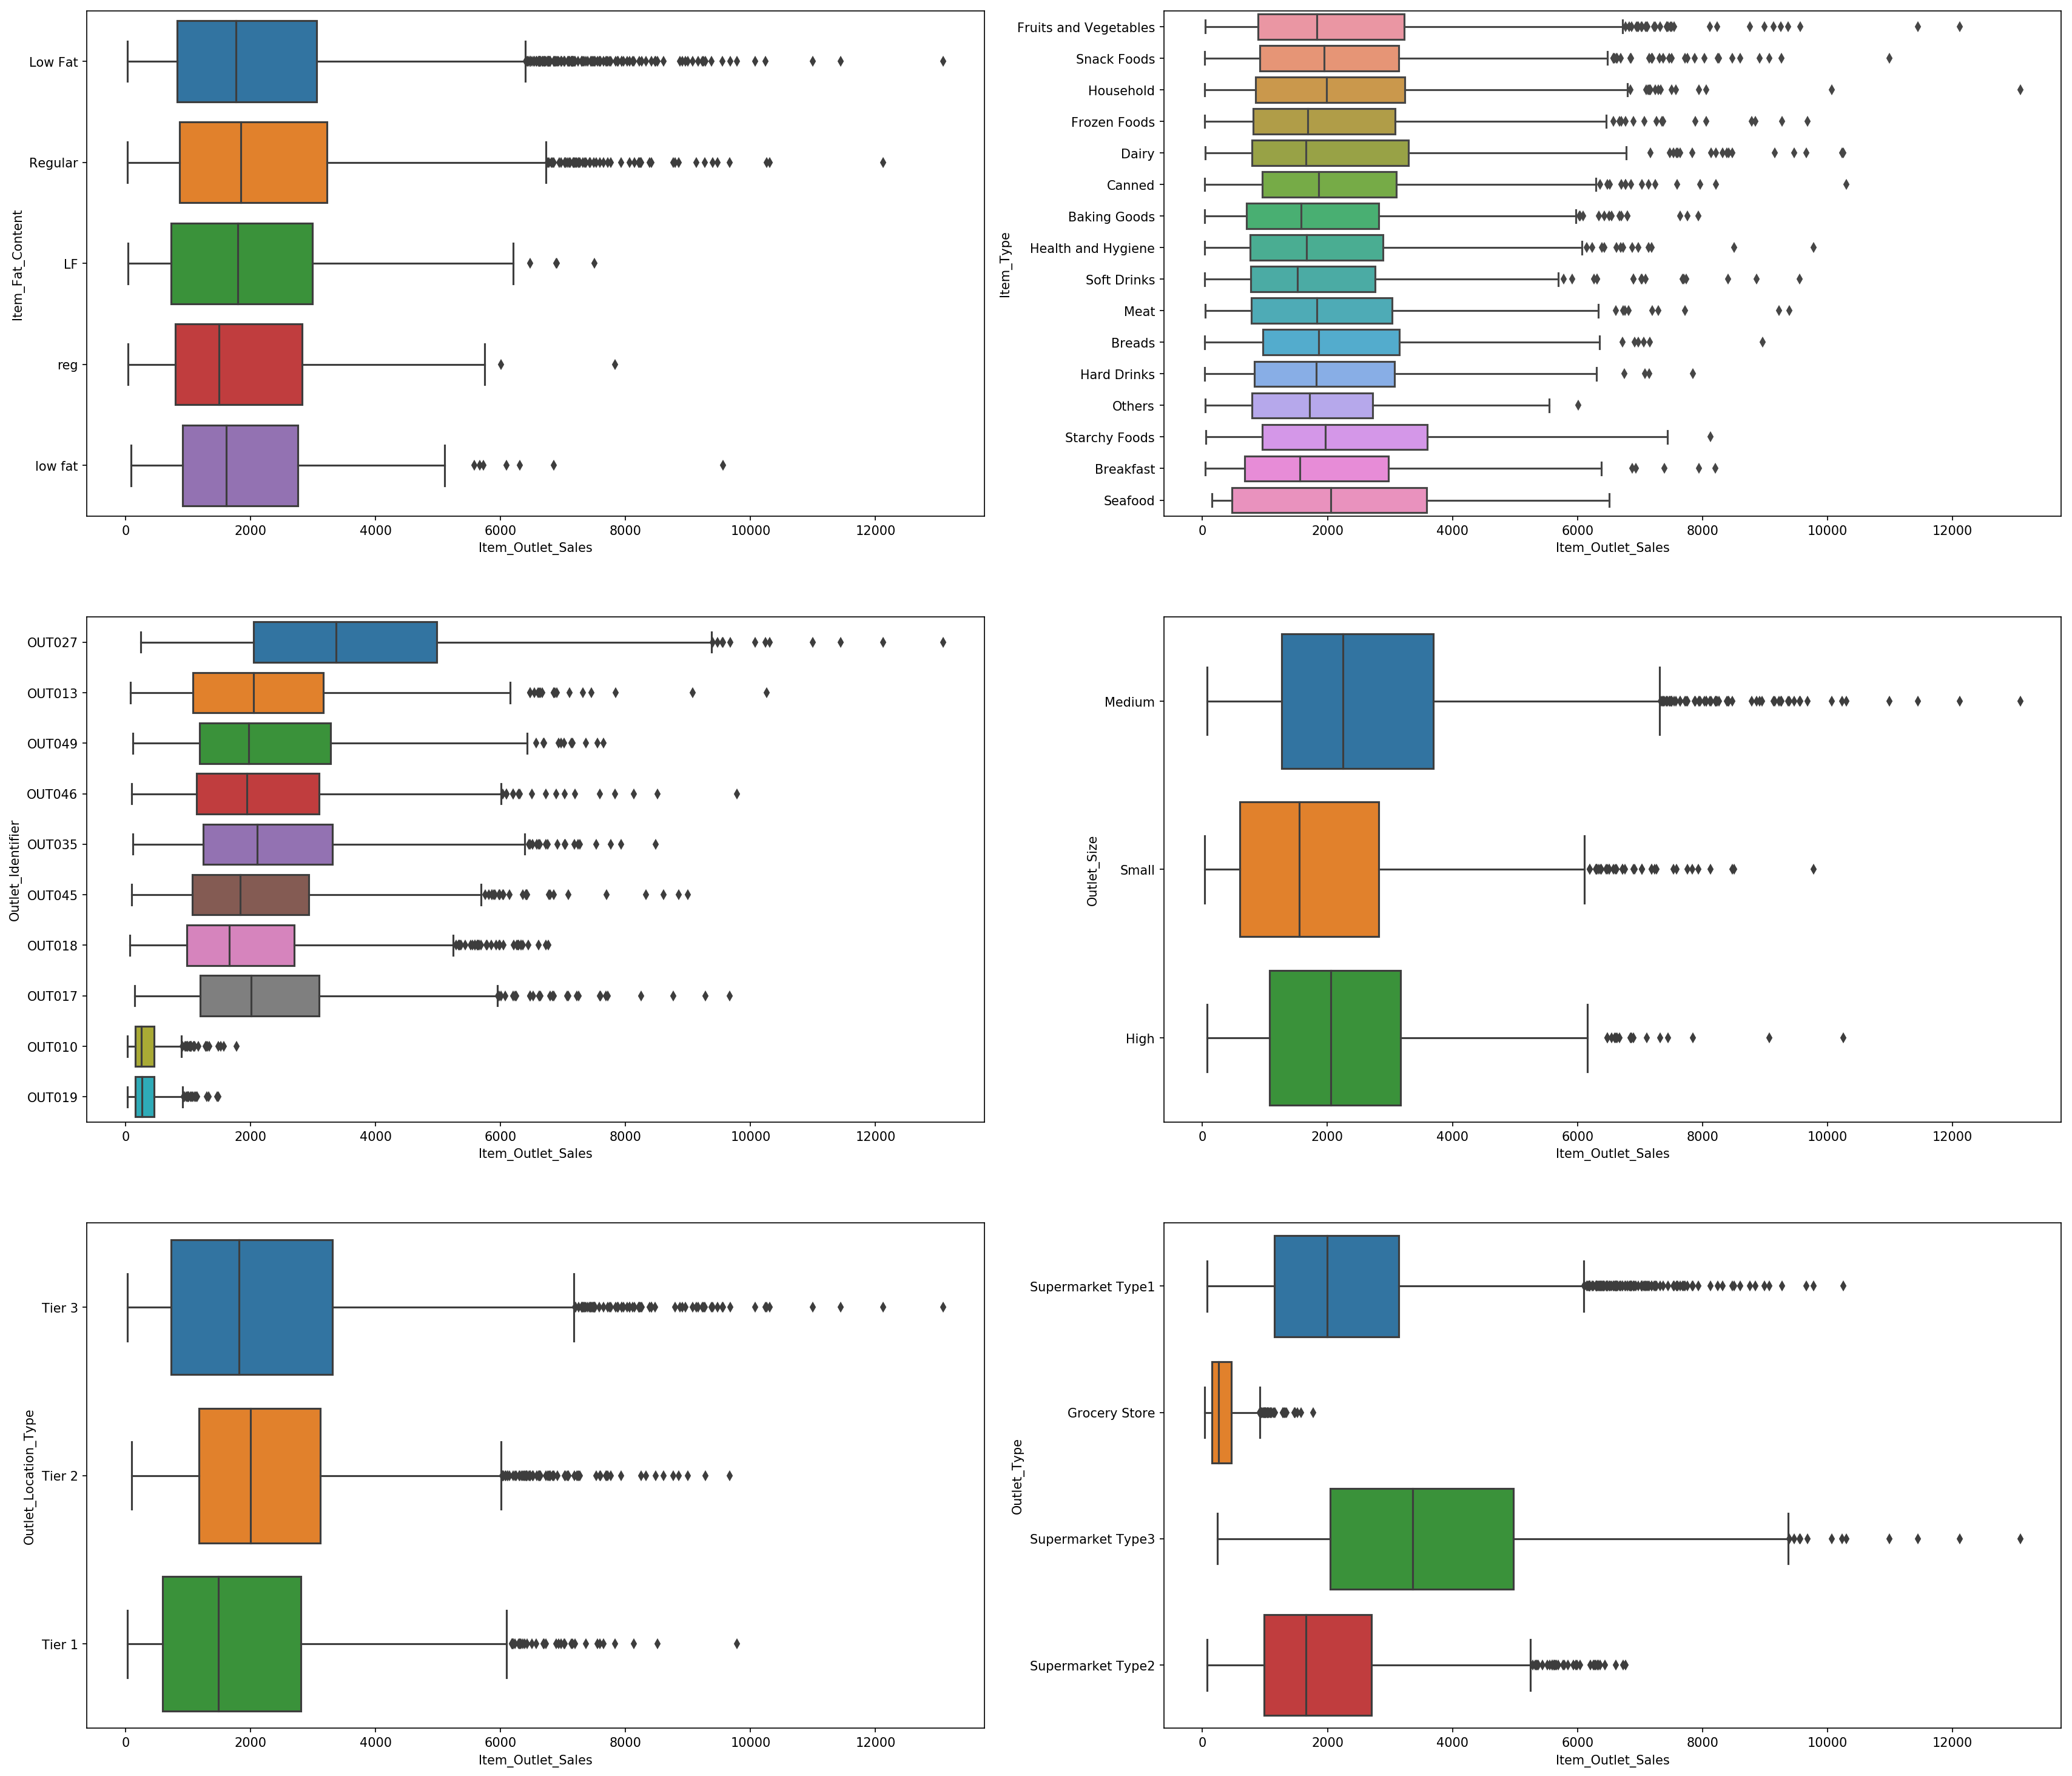

In [9]:
plt.figure(figsize=(28,25),dpi=150)

for i in range(0, len(categorical_columns)):
    plt.subplot(3,2,i+1)
    order = df_train[categorical_columns[i]].value_counts().index
    sns.boxplot(x='Item_Outlet_Sales',
                y=categorical_columns[i], 
                data=df_train,  order=order)
plt.show()

# 3.Data Cleaning & Feature Engineering

### 3.1 check missing values

In [10]:
print("Train NaN Values:")
print(df_train.isnull().sum())
print()
print("Test NaN Values:")
print(df_test.isnull().sum())

Train NaN Values:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
train_test                      0
dtype: int64

Test NaN Values:
Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
train_test                      0
dtype: int64


### 3.2 fill Item_Weight missing values

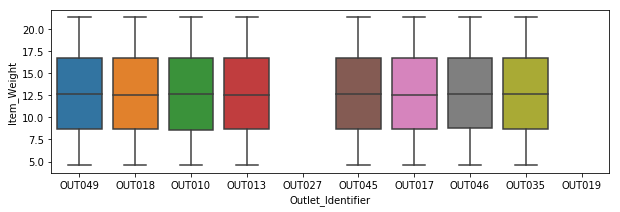

In [11]:
plt.figure(figsize=(10,3))
sns.boxplot(x='Outlet_Identifier',
            y='Item_Weight',data=df_all)

In [12]:
#df_all.groupby('Item_Identifier')['Item_Weight'].agg(['mean'])
item_avg_weight = df_all.pivot_table(values='Item_Weight', 
                                     index='Item_Identifier',
                                     aggfunc='mean')
display(item_avg_weight.head(5))
item_avg_weight = item_avg_weight.to_dict()['Item_Weight']

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [13]:
miss_loc = df_all['Item_Weight'].isnull() 
df_all.loc[miss_loc,'Item_Weight'] = df_all.loc[miss_loc,'Item_Identifier'].map(item_avg_weight)

print ('Final #missing: %d'% sum(df_all['Item_Weight'].isnull()))

Final #missing: 0


### 3.3 fill Outlet_Size missing values

In [14]:
# These 3 outlets provide no item count
miss_loc = df_all['Outlet_Size'].isnull() 
df_all.loc[miss_loc,'Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [15]:
df_all.groupby(['Outlet_Identifier','Outlet_Type','Outlet_Location_Type'])['Item_Identifier'].count()\
      .reset_index().rename(columns={'Item_Identifier':'Outlet_Item_Count'})

#OUT10 - grocery - small
#OUT045 - type1 - small
#OUT017 - type1 - small


,Outlet_Identifier,Outlet_Type,Outlet_Location_Type,Outlet_Item_Count
0,OUT010,Grocery Store,Tier 3,925
1,OUT013,Supermarket Type1,Tier 3,1553
2,OUT017,Supermarket Type1,Tier 2,1543
3,OUT018,Supermarket Type2,Tier 3,1546
4,OUT019,Grocery Store,Tier 1,880
5,OUT027,Supermarket Type3,Tier 3,1559
6,OUT035,Supermarket Type1,Tier 2,1550
7,OUT045,Supermarket Type1,Tier 2,1548
8,OUT046,Supermarket Type1,Tier 1,1550
9,OUT049,Supermarket Type1,Tier 1,1550


In [16]:
from scipy.stats import mode
outlet_size_mode = df_all.pivot_table(values='Outlet_Size', 
                                      columns='Outlet_Type',
                                      aggfunc=(lambda x:mode(x).mode[0]) ).transpose().to_dict()['Outlet_Size']
outlet_size_mode

{'Grocery Store': 'Small',
 'Supermarket Type1': 'Small',
 'Supermarket Type2': 'Medium',
 'Supermarket Type3': 'Medium'}

In [17]:
miss_loc = df_all['Outlet_Size'].isnull() 
df_all.loc[miss_loc,'Outlet_Size'] = df_all.loc[miss_loc,'Outlet_Type'].map(outlet_size_mode)

print(sum(df_all['Outlet_Size'].isnull()))

0


### 3.4 Turn Item_Visibility of 0 to mean
Item_Visibility = 0 makes no sense

In [18]:
# Item Type Avg Visibility
visibility_avg = df_all.pivot_table(values='Item_Visibility', 
                   index='Item_Identifier',
                   aggfunc='mean').to_dict()['Item_Visibility']
miss_loc = (df_all['Item_Visibility'] == 0)
df_all.loc[miss_loc,'Item_Visibility'] = df_all.loc[miss_loc,'Item_Identifier'].map(visibility_avg)


In [19]:
Out_Vis_Sum = df_all.groupby('Outlet_Identifier')['Item_Visibility'].sum()
print(Out_Vis_Sum)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return 100*(e_x / e_x.sum())

for out in Out_Vis_Sum.index:
    outlet_bool = (df_all['Outlet_Identifier'] == out)
    df_all.loc[outlet_bool,'Item_Visibility'] = softmax(df_all.loc[outlet_bool,'Item_Visibility'])

Out_Vis_Sum = df_all.groupby('Outlet_Identifier')['Item_Visibility'].sum()
print()
print(Out_Vis_Sum)


Outlet_Identifier
OUT010    97.262021
OUT013    99.581388
OUT017    99.652015
OUT018    99.364324
OUT019    97.248069
OUT027    99.432339
OUT035    99.565685
OUT045    99.489174
OUT046    99.355668
OUT049    99.204899
Name: Item_Visibility, dtype: float64

Outlet_Identifier
OUT010    100.0
OUT013    100.0
OUT017    100.0
OUT018    100.0
OUT019    100.0
OUT027    100.0
OUT035    100.0
OUT045    100.0
OUT046    100.0
OUT049    100.0
Name: Item_Visibility, dtype: float64


In [20]:
#Determine another variable with means ratio
df_all['Item_Visibility_MeanRatio'] = df_all.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
df_all['Item_Visibility_MeanRatio'].describe()


count    14204.000000
mean         1.854257
std          1.851074
min          0.341993
25%          0.760965
50%          1.261520
75%          2.200672
max         26.214556
Name: Item_Visibility_MeanRatio, dtype: float64

### 3.5 Compute outlet operation year

In [21]:
df_all['Outlet_Years'] = 2013 - df_all['Outlet_Establishment_Year']

In [22]:
sorted(df_all['Outlet_Years'].unique())

[4, 6, 9, 11, 14, 15, 16, 26, 28]

In [23]:
df_all.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,train_test,Item_Visibility_MeanRatio,Outlet_Years
0,FDA15,9.30,Low Fat,0.061439,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,3.564763,14
1,DRC01,5.92,Regular,0.061780,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,2.991282,4


In [24]:
df_all['Outlet_Years'].value_counts()

28    2439
26    1553
14    1550
9     1550
16    1550
11    1548
4     1546
6     1543
15     925
Name: Outlet_Years, dtype: int64

### 3.6 parse Item_Identifier 
1. Item_Type2: FDA15 - FD  
2. Item_Type3: FDA15 - FDA

In [25]:
print(df_all['Item_Identifier'].nunique())

df_all['Item_Type2'] = df_all['Item_Identifier'].apply(lambda x: x[:2])\
                                                .map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})
                                     
df_all['Item_Type2'].value_counts()

1559


Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type2, dtype: int64

In [26]:
print(df_all['Item_Identifier'].nunique())

df_all['Item_Type3'] = df_all['Item_Identifier'].apply(lambda x: x[:3])
print('Unique Item_Type3: ', df_all['Item_Type3'].nunique())

1559
Unique Item_Type3:  71


### 3.7 clean Item_Fat_Content 
compute fat level for each item

In [27]:
df_all['Item_Type2'].unique()

array(['Food', 'Drinks', 'Non-Consumable'], dtype=object)

In [28]:
print(df_all['Item_Fat_Content'].unique())

df_all['Item_Fat_Content'] = df_all['Item_Fat_Content'].map({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat','Regular':'Regular','Low Fat':'Low Fat'})
print(df_all['Item_Fat_Content'].value_counts())


['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [29]:
df_all.loc[df_all['Item_Type2']=="Non-Consumable", 'Item_Fat_Content']="Non-Edible"
df_all.loc[df_all['Item_Type']=="Household", 'Item_Fat_Content']="Non-Edible"
df_all.loc[df_all['Item_Type']=="Health and Hygiene", 'Item_Fat_Content']="Non-Edible"
df_all.loc[df_all['Item_Type']=="Others", 'Item_Fat_Content']="Non-Edible"
print(df_all['Item_Fat_Content'].value_counts())

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64


In [30]:
sum(df_all['Item_Fat_Content'].isnull())

0

### 3.8 Outlet Type is Supermarket or Grocery 

In [31]:
sorted(df_all['Outlet_Type'].unique().tolist())

['Grocery Store',
 'Supermarket Type1',
 'Supermarket Type2',
 'Supermarket Type3']

In [32]:
def isSupermarket(Outlet_Type):
    if Outlet_Type.startswith('Supermarket'):
        return 1
    else:
        return 0
df_all['isSupermarket'] = df_all['Outlet_Type'].map(isSupermarket)

### 3.9 Item_MRP Level feature

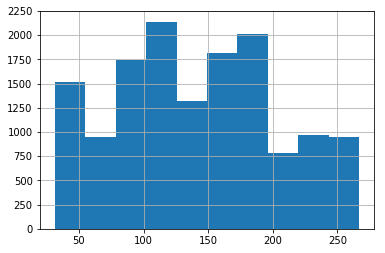

In [33]:
df_all['Item_MRP'].hist()

In [34]:
def mrp_level(mrp):
    if mrp < 70:
        return 'Low'
    elif mrp < 140:
        return 'Medium'
    elif mrp < 210:
        return 'High'
    else:
        return 'Very_High'
df_all['Item_MRP_Level'] = df_all['Item_MRP'].map(mrp_level)

In [35]:
df_all['Item_MRP_Level'].value_counts()

High         5002
Medium       4707
Very_High    2287
Low          2208
Name: Item_MRP_Level, dtype: int64

### 3.10 Compute Aggregation Features
by Outlet_Identifier, Item_MRP mean and set

In [36]:
aggregation = df_all.groupby('Outlet_Identifier')['Item_MRP'].agg(['mean','std']).reset_index()\
                 .rename(columns={
                     'mean': 'By_Outlet_Identifier_MRP_Mean',
                     'std': 'By_Outlet_Identifier_MRP_Std'
})
print(aggregation.shape)
display(aggregation.head(2))

df_all = df_all.merge(aggregation,how='left',on='Outlet_Identifier')

(10, 3)


,Outlet_Identifier,By_Outlet_Identifier_MRP_Mean,By_Outlet_Identifier_MRP_Std
0,OUT010,141.159742,62.010835
1,OUT013,141.128428,62.140848


In [37]:
aggregation = df_all.groupby('Item_Type3')['Item_MRP'].agg(['mean','std']).reset_index()\
                 .rename(columns={
                     'mean': 'By_Item_Type3_MRP_Mean',
                     'std': 'By_Item_Type3_MRP_Std'
})
print(aggregation.shape)
display(aggregation.head(2))

df_all = df_all.merge(aggregation,how='left',on='Item_Type3')

(71, 3)


,Item_Type3,By_Item_Type3_MRP_Mean,By_Item_Type3_MRP_Std
0,DRA,164.314848,17.844147
1,DRB,133.743264,57.980784


In [38]:
fat_level = df_all.groupby(['Item_Type','Item_Fat_Content'])['Item_Fat_Content']\
                  .agg(['count']).reset_index()\
                  .rename(columns={'count':'Item_Fat_Level'})
display(fat_level.head())

df_all = df_all.merge(fat_level, how = 'left', on = ['Item_Type','Item_Fat_Content'])

,Item_Type,Item_Fat_Content,Item_Fat_Level
0,Baking Goods,Low Fat,542
1,Baking Goods,Regular,544
2,Breads,Low Fat,222
3,Breads,Regular,194
4,Breakfast,Low Fat,66


### 3.11 Encode Ordered Factor and 2 Class Factor

In [39]:
df_all['Outlet_Size'].unique()

array(['Medium', 'Small', 'High'], dtype=object)

In [40]:
df_all['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'Non-Edible'], dtype=object)

In [41]:
df_all['Outlet_Size']=df_all['Outlet_Size'].map({'Small':1,'Medium':3,'High':5}) 
df_all['Item_Fat_Content']=df_all['Item_Fat_Content'].map({'Regular':5,'Low Fat':3,'Non-Edible':1})

### 3.12 Encoded Categorical Factor (One Hot Encoding)

In [42]:
train_test = df_all['train_test']

In [43]:
numeric_features = df_all.select_dtypes(exclude=['object'])
numeric_features.head(1)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Visibility_MeanRatio,Outlet_Years,isSupermarket,By_Outlet_Identifier_MRP_Mean,By_Outlet_Identifier_MRP_Std,By_Item_Type3_MRP_Mean,By_Item_Type3_MRP_Std,Item_Fat_Level
0,9.3,3,0.061439,249.8092,1999,3,3735.138,3.564763,14,1,141.163199,62.144594,152.065381,59.822985,691


In [44]:
categorical_features = df_all.select_dtypes(include=['object']).drop(['Item_Identifier','train_test'],1)
categorical_features.head(1)

,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Item_Type2,Item_Type3,Item_MRP_Level
0,Dairy,OUT049,Tier 1,Supermarket Type1,Food,FDA,Very_High


In [45]:
categorical_features_ohe = pd.get_dummies(categorical_features)
categorical_features_ohe.head(2)

,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type2_Drinks,Item_Type2_Food,Item_Type2_Non-Consumable,Item_Type3_DRA,Item_Type3_DRB,Item_Type3_DRC,Item_Type3_DRD,Item_Type3_DRE,Item_Type3_DRF,Item_Type3_DRG,Item_Type3_DRH,Item_Type3_DRI,Item_Type3_DRJ,Item_Type3_DRK,Item_Type3_DRL,Item_Type3_DRM,Item_Type3_DRN,Item_Type3_DRO,Item_Type3_DRP,Item_Type3_DRQ,Item_Type3_DRY,Item_Type3_DRZ,Item_Type3_FDA,Item_Type3_FDB,Item_Type3_FDC,Item_Type3_FDD,Item_Type3_FDE,Item_Type3_FDF,Item_Type3_FDG,Item_Type3_FDH,Item_Type3_FDI,Item_Type3_FDJ,Item_Type3_FDK,Item_Type3_FDL,Item_Type3_FDM,Item_Type3_FDN,Item_Type3_FDO,Item_Type3_FDP,Item_Type3_FDQ,Item_Type3_FDR,Item_Type3_FDS,Item_Type3_FDT,Item_Type3_FDU,Item_Type3_FDV,Item_Type3_FDW,Item_Type3_FDX,Item_Type3_FDY,Item_Type3_FDZ,Item_Type3_NCA,Item_Type3_NCB,Item_Type3_NCC,Item_Type3_NCD,Item_Type3_NCE,Item_Type3_NCF,Item_Type3_NCG,Item_Type3_NCH,Item_Type3_NCI,Item_Type3_NCJ,Item_Type3_NCK,Item_Type3_NCL,Item_Type3_NCM,Item_Type3_NCN,Item_Type3_NCO,Item_Type3_NCP,Item_Type3_NCQ,Item_Type3_NCR,Item_Type3_NCS,Item_Type3_NCT,Item_Type3_NCU,Item_Type3_NCV,Item_Type3_NCW,Item_Type3_NCX,Item_Type3_NCY,Item_Type3_NCZ,Item_MRP_Level_High,Item_MRP_Level_Low,Item_MRP_Level_Medium,Item_MRP_Level_Very_High
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 3.13 drop unnecessary features

In [46]:
df_all_new = pd.concat([train_test,numeric_features,categorical_features_ohe],1)
train = df_all_new[df_all_new['train_test']=='train']

trainX = train.drop(['Item_Outlet_Sales','train_test'],1)
trainY = train['Item_Outlet_Sales']
testX = df_all_new[df_all_new['train_test']=='test'].drop(['Item_Outlet_Sales','train_test'],1)

X_columns = trainX.columns

print('Training Set Shape:', trainX.shape)
print('Test Set Shape:',testX.shape)

Training Set Shape: (8523, 125)
Test Set Shape: (5681, 125)


# 4. Train Model

In [47]:
from sklearn.model_selection import train_test_split
df_all_new = pd.concat([train_test,numeric_features,categorical_features_ohe],1)
train = df_all_new[df_all_new['train_test']=='train']

trainX = train.drop(['Item_Outlet_Sales','train_test'],1)
trainY = train['Item_Outlet_Sales']
testX = df_all_new[df_all_new['train_test']=='test'].drop(['Item_Outlet_Sales','train_test'],1)


max_trainY = np.max(trainY)
trainX_ = trainX
trainY_ = trainY/max_trainY

In [48]:
trainX, validX, trainY, validY = train_test_split(trainX, 
                                                  trainY/max_trainY, 
                                                  test_size=0.2, random_state=32)



In [49]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### 4.1 train  benchmark model

In [50]:
reg = LinearRegression()
reg.fit(trainX, trainY)

trainY_pred = reg.predict(trainX)
print(rmse(trainY_pred*max_trainY, trainY*max_trainY))

validY_pred = reg.predict(validX)
print(rmse(validY_pred*max_trainY, validY*max_trainY))

1120.6695059311146
1144.1368306294257


In [51]:
reg = ElasticNet(alpha=0.001)
reg.fit(trainX, trainY)

trainY_pred = reg.predict(trainX)
print(rmse(trainY_pred*max_trainY, trainY*max_trainY))

validY_pred = reg.predict(validX)
print(rmse(validY_pred*max_trainY, validY*max_trainY))

1126.7768310158083
1138.6896074157364


In [68]:
reg = DecisionTreeRegressor(max_depth=5, min_samples_split=6)
reg.fit(trainX, trainY)

trainY_pred = reg.predict(trainX)
print(rmse(trainY_pred*max_trainY, trainY*max_trainY))

validY_pred = reg.predict(validX)
print(rmse(validY_pred*max_trainY, validY*max_trainY))

1068.9748545085254
1102.1838208838285


In [54]:
reg = RandomForestRegressor(n_estimators=300, 
                            max_depth = 50,
                            max_leaf_nodes=10)
reg.fit(trainX, trainY)

trainY_pred = reg.predict(trainX)
print(rmse(trainY_pred*max_trainY, trainY*max_trainY))

validY_pred = reg.predict(validX)
print(rmse(validY_pred*max_trainY, validY*max_trainY))

1077.9858402634711
1097.290040671221


In [55]:
reg = GradientBoostingRegressor(n_estimators=1200, 
                                learning_rate=0.01,
                                min_samples_split = 15,
                                subsample = 0.4, 
                                max_leaf_nodes = 5,
                                max_features = 'sqrt')
reg.fit(trainX, trainY)

trainY_pred = reg.predict(trainX)
print(rmse(trainY_pred*max_trainY, trainY*max_trainY))

validY_pred = reg.predict(validX)
print(rmse(validY_pred*max_trainY, validY*max_trainY))

1050.664536095346
1096.7903621424332


### 4.2 fine tune GBDT

In [78]:
from sklearn.model_selection import GridSearchCV

gbdt = GradientBoostingRegressor(n_estimators=1200, 
                                learning_rate=0.01,
                                subsample = 0.4, 
                                max_features = 'sqrt')

parameters = {'min_samples_split':[8, 10,15], 
              'max_leaf_nodes':[5, 8],
              'subsample':[0.4,0.5]}

grid_obj = GridSearchCV(gbdt, parameters, cv=3)
grid_obj.fit(trainX, trainY)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_sa...       subsample=0.4, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': (8, 10, 15), 'max_leaf_nodes': [5, 8], 'subsample': [0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
grid_obj.best_params_

{'max_leaf_nodes': 5, 'min_samples_split': 10, 'subsample': 0.5}

In [80]:
gbdt = GradientBoostingRegressor(n_estimators=1200, 
                                learning_rate=0.01,
                                subsample = 0.5, 
                                max_features = 'sqrt',
                                min_samples_split = 10,
                                max_leaf_nodes = 5)
gbdt.fit(trainX_, trainY_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=5,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=1200,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=0.5, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

### 4.3 feature importence bar plot

In [81]:
#### gbdt feature importance
df_importance = pd.DataFrame(data = {'features':list(trainX_.columns),
                     'feature_importances': gbdt.feature_importances_})\
    .sort_values('feature_importances',ascending=False).iloc[0:15,].reset_index(drop=True)
df_importance

,features,feature_importances
0,Item_MRP,0.251807
1,Item_MRP_Level_Low,0.118757
2,Item_MRP_Level_Very_High,0.109252
3,Outlet_Type_Grocery Store,0.072191
4,By_Outlet_Identifier_MRP_Std,0.063753
5,isSupermarket,0.053112
6,Outlet_Type_Supermarket Type3,0.046638
7,Outlet_Identifier_OUT027,0.045781
8,Item_Visibility,0.043275
9,Item_MRP_Level_Medium,0.030281


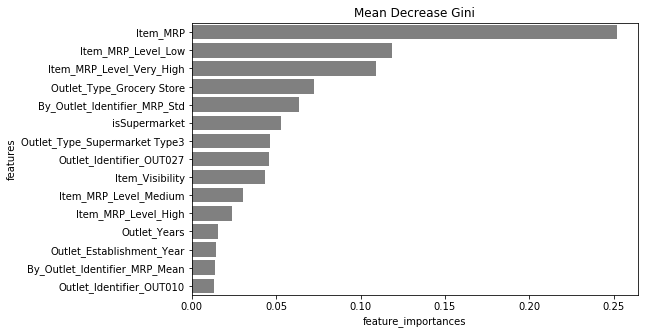

In [82]:
#plot
plt.figure(figsize=(8,5))
sns.barplot(x="feature_importances", y="features", data=df_importance,
           color='grey')
plt.title('Mean Decrease Gini')
plt.show()

### 4.4 predict on test and save submission

In [83]:
testY_pred = gbdt.predict(testX)*max_trainY

testID = df_all[df_all.train_test=='test'][['Item_Identifier','Outlet_Identifier']]
testID['Item_Outlet_Sales'] = testY_pred
testID.head()

testID.to_csv('Submission.csv',index=None)